# Demo: Gaussian processes under monotonicity constraints in 5D

In this notebook, we propose a demo example of the implementation of a Gaussian process (GP) under monotonicity constraints. The model is constructed via the MaxMod algorithm proposed in [1]

[1] F. Bachoc, A. F. López-Lopera, and O. Roustant (2020). *Sequential construction and dimension reduction of Gaussian
processes under inequality constraints*, SIAM Journal on Mathematics of Data Science, 4(2). URL: https://arxiv.org/abs/2009.04188.

In [1]:
# loading useful libraries
library("lineqGPR")
require("DiceDesign")
library("plot3D")
library("viridis")

rm(list=ls())
options(warn=-1)

Le chargement a nécessité le package : broom

Le chargement a nécessité le package : nloptr

Le chargement a nécessité le package : purrr

Le chargement a nécessité le package : DiceDesign

Le chargement a nécessité le package : viridisLite



In [2]:
# Synthetic data: monotonic function
modatan <- function(x, a) return(atan(a*x))
targetFun <- function(x, d) {
  y <- 0
  a <- (1-(1:d)/(d+1))*5
  for (k in 1:d)
    y <- y + modatan(x[, k], a[k])
  return(y)
}

In [3]:
D <- 5 # number of active + inactive input variables
d <- 2 # number of active input variables

# building DoE in dimension D via Latin hypercube sampling (LHS)
nbtrain <- 20*D # nb of training data
xdesign <- lhsDesign(nbtrain, D, seed = 8)$design
xdesign <- maximinSA_LHS(xdesign)$design
ydesign <- targetFun(xdesign, d)

# building a DoE for assessing the model
ntest <- 80*D # nb of test data for the MaxMod criterion
xtest <- lhsDesign(ntest, D, seed = 8)$design
xtest <- maximinSA_LHS(xtest)$design

In [4]:
# initializing a 1D GP model with only two knots 
model <-  create(class = 'lineqGP',
                 x = xdesign, y = ydesign,
                 constrType = c("monotonicity"), m = 2)
model$kernParam$type <- "matern52"
model$varnoise <- var(ydesign)
model$kernParam$nugget <- 1e-5

In [5]:
# updating the model according to the MaxMod algorithm
model <- MaxMod(model,
                xtest,
                tol = 1e-5,
                max_iter = 10*model$d,
                reward_new_knot = 1e-6,
                reward_new_dim = 1e-9,
                print_iter = TRUE,
                nClusters = 10,
                save_history = TRUE)

message("\nNumber of active dimensions: ", d)
message("Number of actived dimensions via MaxMod: ", model$d, "\n")

                    dim 1    dim 2    dim 3    dim 4    dim 5
MaxMod criterion 1.224175 1.218699 1.179208 1.177648 1.177618
knot's position       NaN      NaN      NaN      NaN      NaN
decision         1.000000 0.000000 0.000000 0.000000 0.000000


Iter 1 - dimension 1 added as d = 1 (Relative MaxMod criterion = Inf)



                     dim 1      dim 2        dim 3      dim 4       dim 5
MaxMod criterion 0.0192993 0.04813455 0.0001500005 0.00056587 0.000322478
knot's position  0.3828852        NaN          NaN        NaN         NaN
decision         0.0000000 1.00000000 0.0000000000 0.00000000 0.000000000


Iter 2 - dimension 2 added as d = 2 (Relative MaxMod criterion = 0.0196599955428449)



                       dim 1       dim 2        dim 3       dim 4        dim 5
MaxMod criterion 0.006794786 0.002083123 0.0001326933 7.98185e-05 3.507365e-05
knot's position  0.387948526 0.401963188          NaN         NaN          NaN
decision         1.000000000 0.000000000 0.0000000000 0.00000e+00 0.000000e+00


Iter 3 - New knot added: d = 1 (Relative MaxMod criterion = 0.00264733162378639)



                        dim 1       dim 2       dim 3        dim 4        dim 5
MaxMod criterion 5.236818e-05 0.001063345 7.04391e-05 2.764974e-05 1.737428e-05
knot's position  6.873629e-01 0.459723937         NaN          NaN          NaN
decision         0.000000e+00 1.000000000 0.00000e+00 0.000000e+00 0.000000e+00


Iter 4 - New knot added: d = 2 (Relative MaxMod criterion = 0.000424805846771087)



                        dim 1        dim 2        dim 3        dim 4
MaxMod criterion 0.0000479849 0.0000359026 2.676007e-05 5.372877e-06
knot's position  0.7515225917 0.6762823783          NaN          NaN
decision         1.0000000000 0.0000000000 0.000000e+00 0.000000e+00
                        dim 5
MaxMod criterion 9.188451e-06
knot's position           NaN
decision         0.000000e+00


Iter 5 - New knot added: d = 1 (Relative MaxMod criterion = 1.93455246660833e-05)



                        dim 1        dim 2        dim 3       dim 4
MaxMod criterion 0.0002026479 2.851644e-05 1.547175e-05 4.06623e-06
knot's position  0.2131210895 6.698768e-01          NaN         NaN
decision         1.0000000000 0.000000e+00 0.000000e+00 0.00000e+00
                        dim 5
MaxMod criterion 8.370995e-06
knot's position           NaN
decision         0.000000e+00


Iter 6 - New knot added: d = 1 (Relative MaxMod criterion = 7.87941516484455e-05)



                        dim 1        dim 2        dim 3        dim 4
MaxMod criterion 1.174631e-05 1.780466e-05 7.725338e-06 1.108001e-06
knot's position  5.314749e-01 7.038163e-01          NaN          NaN
decision         0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
                        dim 5
MaxMod criterion 1.668296e-06
knot's position           NaN
decision         0.000000e+00


Iter 7 - New knot added: d = 2 (Relative MaxMod criterion = 7.01296422197603e-06)

The sequential algorithm converged


Number of active dimensions: 2

Number of actived dimensions via MaxMod: 2




In [6]:
# evaluating the model using an equispaced grid of points
ntest <- 10
xtestGrid  <- as.matrix(expand.grid(seq(0, 1, length = ntest), seq(0, 1, length = ntest)))
ytestGrid <- targetFun(xtestGrid, d)
pred <- predict(model, xtestGrid)

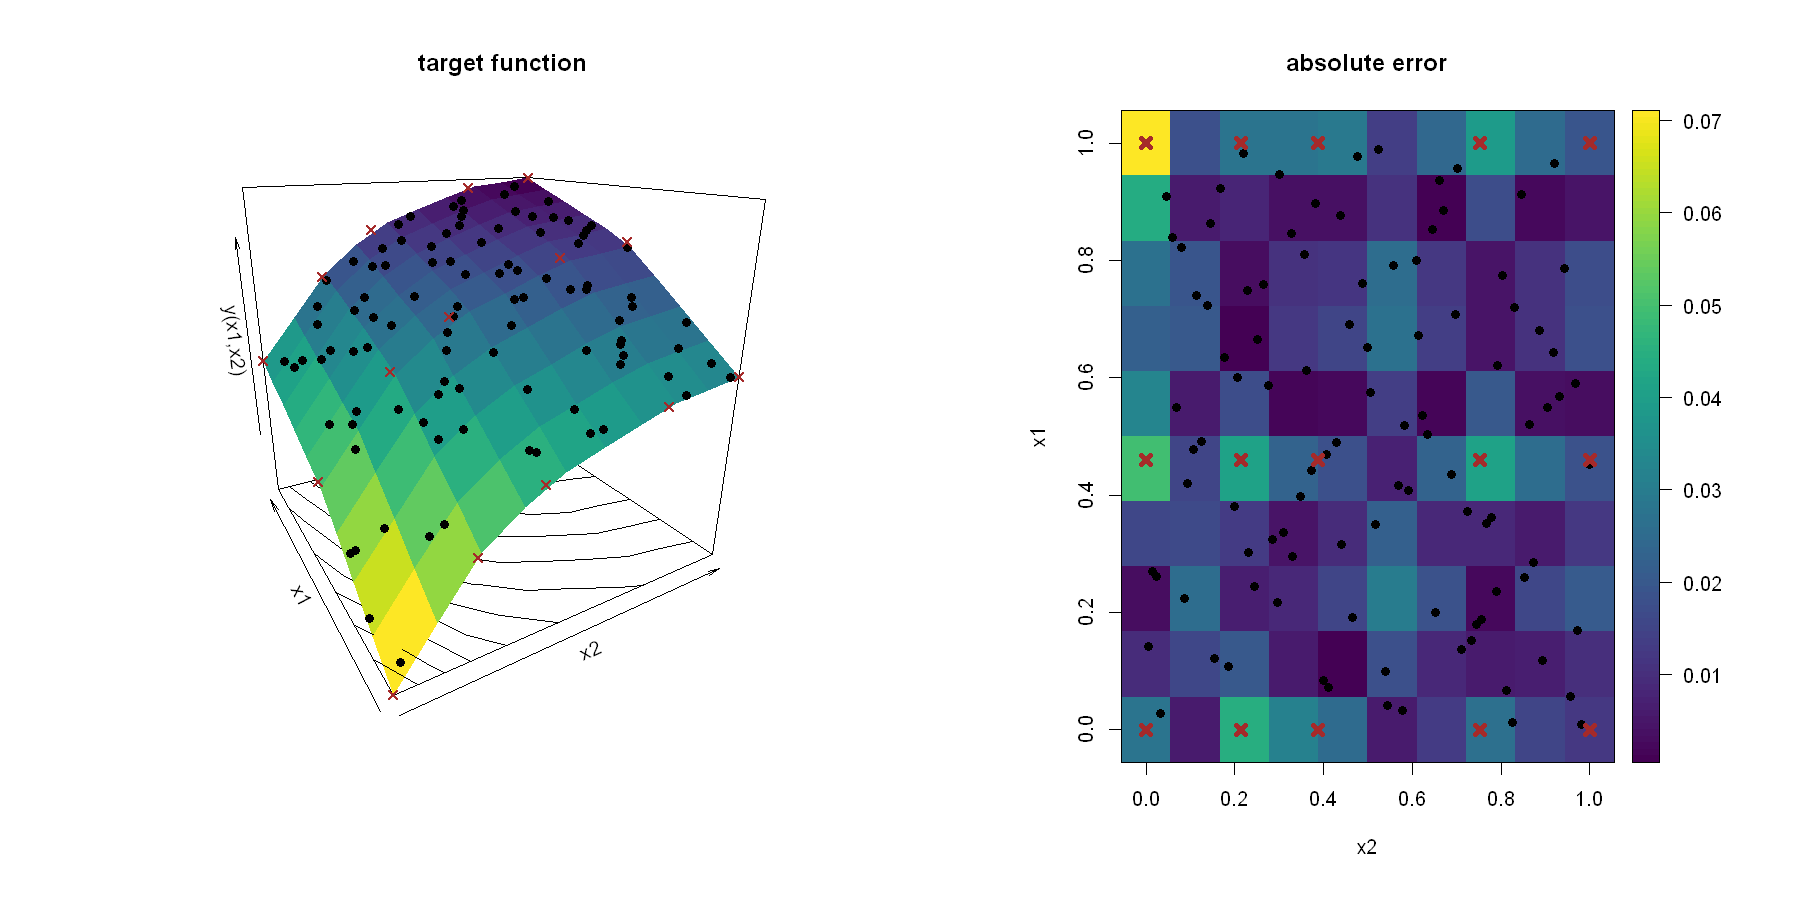

In [7]:
# plotting the MAP estimate
colormap <- rev(viridis(1e2))
options(repr.plot.width = 15, repr.plot.height = 7.5)
par(mfrow = c(1,2))
p <- persp3D(x = seq(0, 1, length = ntest), y = seq(0, 1, length = ntest),
             z = matrix(pred$Phi.test %*% pred$xi.map, nrow = ntest),
             xlab = "x2", ylab = "x1", zlab = "y(x1,x2)",
             main = "target function",
             phi = 20, theta = -30, col = colormap,
             contour = TRUE, colkey=FALSE)
points(trans3D(x = model$x[, 1], y = model$x[, 2], z = ydesign, pmat = p),
       col = 'black', pch = 19)
u <- expand.grid(model$ulist[[1]], model$ulist[[2]])
pred_Knots <- predict(model, as.matrix(u))
points(trans3D(x = u[, 1], y = u[, 2], z = pred_Knots$Phi.test %*% pred_Knots$xi.map, pmat = p),
       col = 'brown', pch = 4, lwd = 2)

diff = ytestGrid - pred$Phi.test %*% pred$xi.map
image2D(abs(matrix(diff, nrow = ntest)), col = rev(colormap),
        main = "absolute error", xlab = "x2", ylab = "x1")
points2D(model$x[, 1], model$x[, 2], add = TRUE, pch = 19, col ='black')
points2D(u[, 1], u[, 2], add = TRUE, pch = 4, lwd = 4, col ='brown')